#Neural network classification

###make classification data

In [ ]:
import sklearn
from sklearn.datasets import make_circles

In [ ]:
n_samples = 1000
X,y = make_circles(n_samples, noise=0.03, random_state=42)

In [ ]:
len(X),len(y)

(1000, 1000)

In [ ]:
print(f"X: {X[:5]}")
print(f"y: {y[:5]}")

X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
y: [1 1 1 1 0]


In [ ]:
#make dataframe of circle dta
import pandas as pd
df = pd.DataFrame({"X0":X[:,0], "X1":X[:,1], "y":y})
df.head()

,X0,X1,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


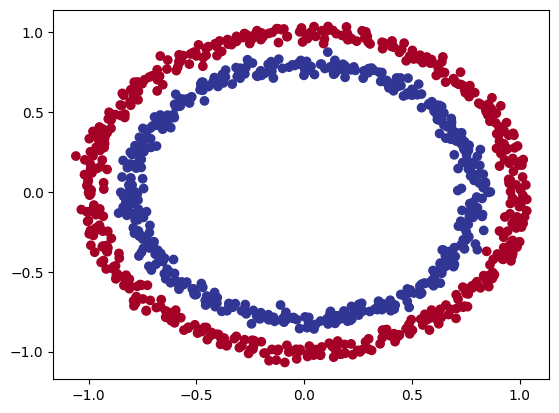

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df["X0"], df["X1"], c=df["y"], cmap=plt.cm.RdYlBu)

###1.1Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X_sample = X[0]
y_sample = y[0]
X_sample, y_sample

(array([0.75424625, 0.23148074]), 1)

###1.2 Turn data into tensors and create test and train splits


In [ ]:
import torch

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X),type(y),X.dtype,y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [ ]:
#splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3301)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

##Building a model

In [ ]:
#setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
#model construction subclassing nn.module

from torch import nn
class CircleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    #create 2 linaer layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5)#takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1)#takes in 5 features and output a single festure(same shape as y)
  #define a forward pass
  def forward(self,x):
    return self.layer_1(self.layer_2(x))
#4. instantiate an instance of our model class and send it to target device
model_0 = CircleModelv0().to(device)
model_0

CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.6283, -0.0043],
        [-0.3141, -0.4835],
        [-0.1363, -0.0620],
        [ 0.1025,  0.3097],
        [-0.1040,  0.5809]], requires_grad=True)

In [ ]:
#using torch>sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()


OrderedDict([('0.weight',
              tensor([[ 0.6739,  0.6865],
                      [-0.2998, -0.5753],
                      [ 0.2180,  0.0917],
                      [-0.2504,  0.6898],
                      [ 0.3638, -0.0763]])),
             ('0.bias', tensor([ 0.3213, -0.3009, -0.3769,  0.0328, -0.0650])),
             ('1.weight',
              tensor([[ 0.3799,  0.3695, -0.1666, -0.1175, -0.2547]])),
             ('1.bias', tensor([-0.2352]))])

In [ ]:
#make predictions
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))
y_logits[:10]
y_test[:10]

tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 0.])

###2.1 setup loss function and optimizer

In [ ]:
#set up the loss function
#loss_fn  = nn.BCELoss()# BCELoss = requires to have gone through sigmoid activation function prior to input to BCE loss
# nn.Sequesntial(
#     nn.Sigmoid(),
#     nn.BCELoss()
# )
loss_fn = nn.BCEWithLogitsLoss()#consists of sigmoid activation function built in.#numeric stability
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)


In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6739,  0.6865],
                      [-0.2998, -0.5753],
                      [ 0.2180,  0.0917],
                      [-0.2504,  0.6898],
                      [ 0.3638, -0.0763]])),
             ('0.bias', tensor([ 0.3213, -0.3009, -0.3769,  0.0328, -0.0650])),
             ('1.weight',
              tensor([[ 0.3799,  0.3695, -0.1666, -0.1175, -0.2547]])),
             ('1.bias', tensor([-0.2352]))])

In [ ]:
#calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()#item used because we ant to get a single number
  acc = (correct/len(y_pred))*100
  return acc


#Train Model
1. Forward pass
2. calcute the loss
3. optim zero grad
4. loss backward(backprop)
5. optimizer step(gradient descent)

###going from raw logits ->prediction probabilities ->prediction labels
We can convert logits to prediction probabilities by passing them through activation function(sigmoid for binary and softmax for multiclass calssification).
Then we can convert our model prediction probablities to prediction labels using argmax()

In [ ]:
#view the first 5 outputs of the forward pass on the test data.
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[-0.1655],
        [-0.2012],
        [-0.1900],
        [-0.0967],
        [-0.1239]])

In [ ]:
#use the sigmoid activation function on our model logits to turn them into prediction probablities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.4587],
        [0.4499],
        [0.4526],
        [0.4759],
        [0.4691]])

In [ ]:
torch.round(y_pred_probs[:5])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [ ]:
#find the predicted labels
y_preds = torch.round(y_pred_probs)
y_preds[:5]
#in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))
#get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
y_test[:5]

tensor([0., 0., 0., 0., 0.])

###building train and test loop

In [ ]:
torch.manual_seed(42)
#torch.cuda.manual_seed(42)
#BCELoss more numerically stable
#set number of epochs
epochs=200
#put data to target device
#X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  ##training
  model_0.train()
  #1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))# turn logits->pred probs->pred labels
  #2. calculate loss/accuracy
  #loss = loss_fn(torch.sigmoid(y_logits), y_train)# nn.bCELoss expects prediction probablities
  loss = loss_fn(y_logits,#nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true=y_train
                    , y_pred=y_pred)
  #3. Optimize zero grad
  optimizer.zero_grad()
  #4. loss backward
  loss.backward()
  #5. optimizer step
  optimizer.step()
  ##testing
  model_0.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #2. Calculate the test loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    #print
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69410 | Acc: 51.00% | Test Loss: 0.70396 | Test Acc: 46.00%
Epoch: 10 | Loss: 0.69396 | Acc: 51.00% | Test Loss: 0.70365 | Test Acc: 46.00%
Epoch: 20 | Loss: 0.69383 | Acc: 51.00% | Test Loss: 0.70336 | Test Acc: 46.00%
Epoch: 30 | Loss: 0.69371 | Acc: 51.00% | Test Loss: 0.70309 | Test Acc: 46.00%
Epoch: 40 | Loss: 0.69360 | Acc: 51.00% | Test Loss: 0.70284 | Test Acc: 46.00%
Epoch: 50 | Loss: 0.69350 | Acc: 51.00% | Test Loss: 0.70260 | Test Acc: 46.00%
Epoch: 60 | Loss: 0.69341 | Acc: 51.00% | Test Loss: 0.70238 | Test Acc: 46.00%
Epoch: 70 | Loss: 0.69333 | Acc: 51.00% | Test Loss: 0.70217 | Test Acc: 46.00%
Epoch: 80 | Loss: 0.69325 | Acc: 51.00% | Test Loss: 0.70198 | Test Acc: 46.00%
Epoch: 90 | Loss: 0.69318 | Acc: 51.00% | Test Loss: 0.70180 | Test Acc: 46.00%
Epoch: 100 | Loss: 0.69312 | Acc: 51.00% | Test Loss: 0.70163 | Test Acc: 46.00%
Epoch: 110 | Loss: 0.69306 | Acc: 51.00% | Test Loss: 0.70147 | Test Acc: 46.00%
Epoch: 120 | Loss: 0.69301 | Acc: 51.00

###make prediction and evaluate teh model:
it seems our model isnt learning anything so to inspect lets make some predictions and visualize.

To do so, we are going to import a function called plot_decision_boundary

In [ ]:
import requests
from pathlib import Path
#Download helper function from Learn Pytorch repo (if its not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions,plot_decision_boundary

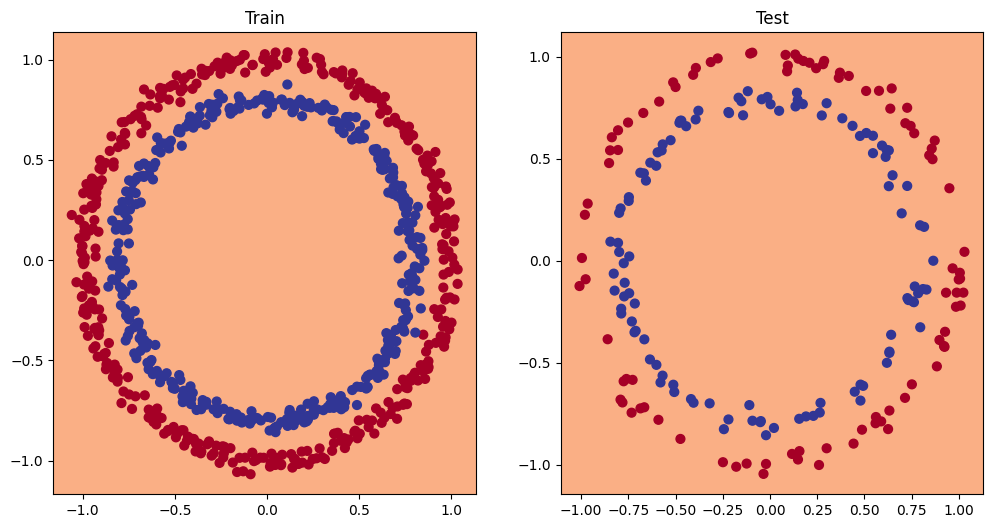

In [ ]:
#plot decison boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

#improving the model
* Add more layers- give the model more chance to learn abt parameters
* Add more hidden units- go from 5 to 10 hidden units
* Fit for longer
* change the learning


In [ ]:
class CircleModelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2,10)
    self.layer_2 = nn.Linear(10,10)
    self.layer_3 = nn.Linear(10,1)
  def forward(self,x):
    # z = self.layer_1(x)
    # z= self.layer_2(x)
    # z = self.layer_3(x)
    #return z
    return self.layer_3(self.layer_2(self.layer_1(x)))#this method leveragres speed ups
model_1= CircleModelv1()
model_1

CircleModelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [ ]:
#Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
#cerate an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
#train for longer
epochs = 1000
#put data to target device(in case gpu)
#X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
for epoch in range(epochs):
  #trianing
  model_1.train()
  #1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))#logits->pred prob->predict label
  #2. calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  #Optimizer zero grad
  optimizer.zero_grad()
  #loss backward
  loss.backward()
  #optimizer step
  optimizer.step()
  #testing
  model_1.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #2. Calculate the test loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    #print
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69500 | Acc: 49.12% | Test Loss: 0.68871 | Test Acc: 56.50%
Epoch: 100 | Loss: 0.69250 | Acc: 46.25% | Test Loss: 0.69777 | Test Acc: 40.00%
Epoch: 200 | Loss: 0.69240 | Acc: 49.50% | Test Loss: 0.69946 | Test Acc: 43.50%
Epoch: 300 | Loss: 0.69239 | Acc: 49.38% | Test Loss: 0.69986 | Test Acc: 43.00%
Epoch: 400 | Loss: 0.69239 | Acc: 49.75% | Test Loss: 0.69995 | Test Acc: 43.00%
Epoch: 500 | Loss: 0.69239 | Acc: 49.88% | Test Loss: 0.69997 | Test Acc: 43.00%
Epoch: 600 | Loss: 0.69239 | Acc: 49.88% | Test Loss: 0.69998 | Test Acc: 43.00%
Epoch: 700 | Loss: 0.69239 | Acc: 49.88% | Test Loss: 0.69998 | Test Acc: 43.00%
Epoch: 800 | Loss: 0.69239 | Acc: 49.88% | Test Loss: 0.69998 | Test Acc: 43.00%
Epoch: 900 | Loss: 0.69239 | Acc: 49.88% | Test Loss: 0.69998 | Test Acc: 43.00%


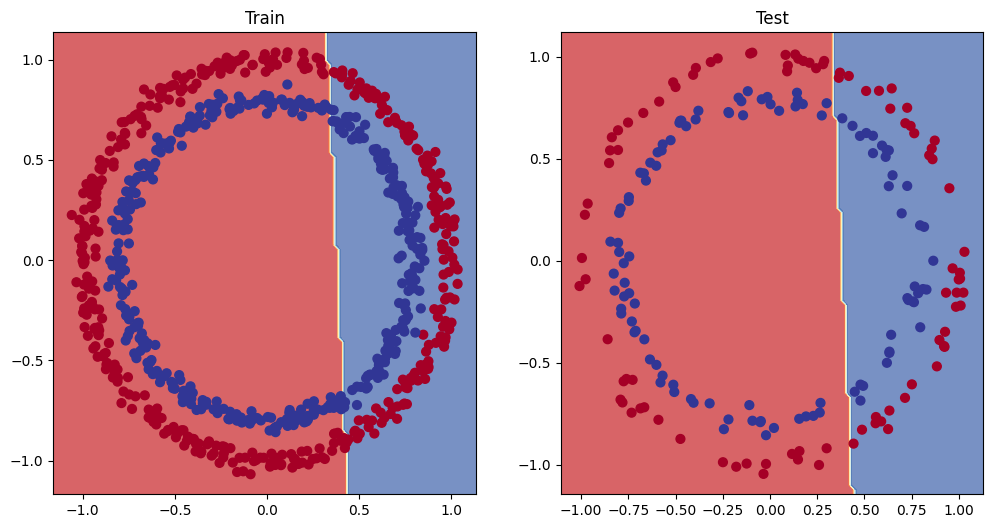

In [ ]:
#plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

###prepare data to see if our model can fit st line


In [ ]:
#create some data set
weight =0.7
bias = 0.3
start=0
end=1
step=.01
X_Regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight*X_Regression + bias
X_Regression[:10],y_regression[:10]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]))

In [ ]:
#create train and test split
train_split = int(0.8*len(X_Regression))
X_train_Regression, y_train_Regression = X_Regression[:train_split], y_regression[:train_split]
X_test_Regression, y_test_Regression = X_Regression[train_split:], y_regression[train_split:]
#check length
len(X_train_Regression), len(y_train_Regression), len(X_test_Regression), len(y_test_Regression)

(80, 80, 20, 20)

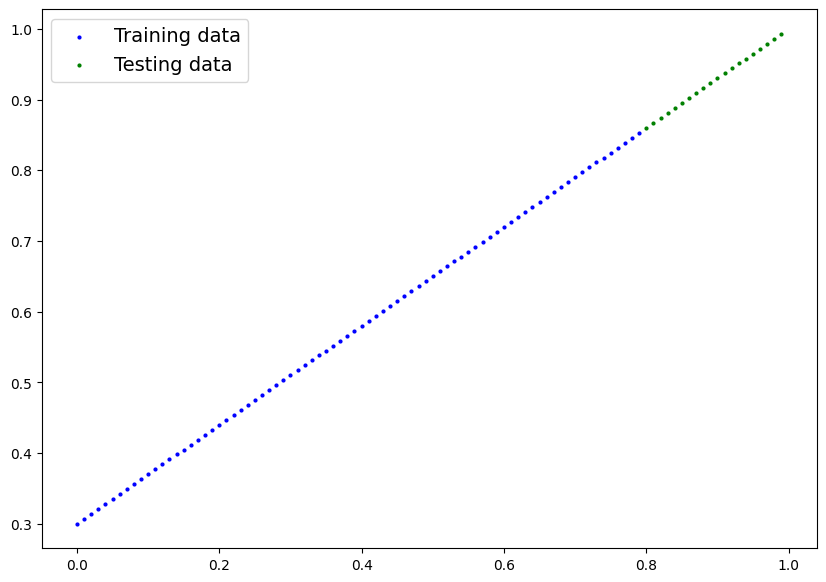

In [ ]:
plot_predictions(train_data=(X_train_Regression),train_labels= (y_train_Regression),
                 test_data=(X_test_Regression), test_labels=(y_test_Regression),
                 predictions=None)

In [ ]:
model_1

CircleModelv1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#ADJUSTING MODEL_1 TO fit staright line
#we have to chasnge in features to be 1 since there is only 1 faeture in xtrain and ytrain regression
model_2 = nn.Sequential(
    nn.Linear(1,10),
    nn.Linear(10,10),
    nn.Linear(10,1)
)
model_2


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#Loss and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [ ]:
#Train the model
torch.manual_seed(42)
#Set nimber of epochs
epochs=1000
#Put data on target device(here we already have it on cpu)
#training
for epoch in range(epochs):
  y_pred = model_2(X_train_Regression)
  loss = loss_fn(y_pred, y_train_Regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
#testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_Regression)
    test_loss = loss_fn(test_pred, y_test_Regression)
#print what is happeneing
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test Loss: 0.00360


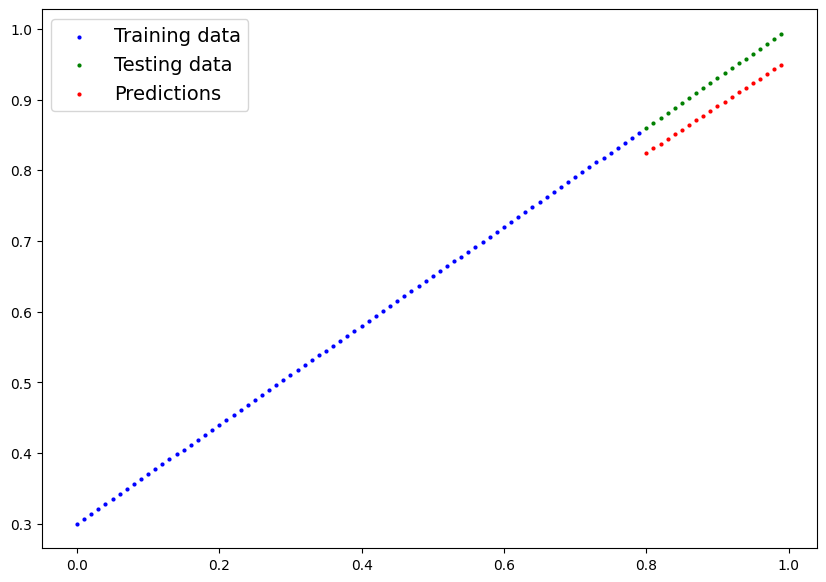

In [ ]:
#turn on evaluation mode
model_2.eval()
with torch.inference_mode():
  y_preds = model_2(X_test_Regression)
#plot data andnn predictions
plot_predictions(train_data=(X_train_Regression),train_labels= (y_train_Regression),
                 test_data=(X_test_Regression), test_labels=(y_test_Regression),
                 predictions=y_preds)

##Non linearty
"what pattern would you draw if you were givn infiniyte amt of straight and non straight lines"


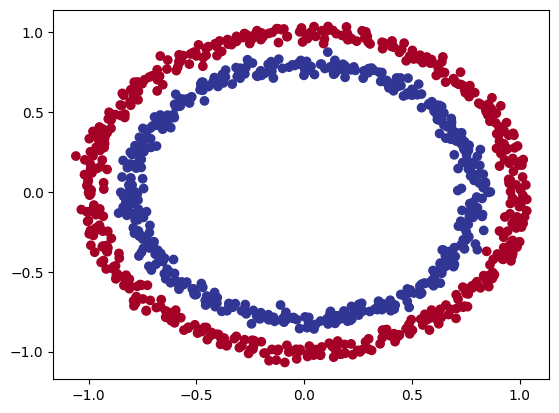

In [ ]:
#create data set again
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples = 1000
X,y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
#convert data to tensors and then to test and train splits
import torch
from sklearn.model_selection import train_test_split
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3301)
X_train[:5],y_train[:5]

(tensor([[ 0.9496,  0.0787],
         [ 0.7456,  0.3130],
         [ 0.1466, -0.9918],
         [ 0.9058,  0.3632],
         [ 0.8040,  0.2231]]),
 tensor([0., 1., 0., 0., 1.]))

In [ ]:
##Building a model with non linearity
from torch import nn
class CircleModelv2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2= nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()
  def forward(self,x):
    #where should we put our non linear activation function
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelv2()
model_3

CircleModelv2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
#set up loss and optmizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

In [ ]:
#training model with non reality
torch.manual_seed(42)
#set number of epochs
epochs = 1000
#put data to target device
#X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
for epoch in range(epochs):
  #training
  model_3.train()
  #1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))#logits->pred prob->pred labels
  #2. calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
  #3. Optimizer zero grad
  optimizer.zero_grad()
  #4. loss backward
  loss.backward()
  #5. optimizer step
  optimizer.step()
  #testing
  model_3.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #2. Calculate the test loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    #print whats happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69314 | Acc: 49.00% | Test Loss: 0.69249 | Test Acc: 54.00%
Epoch: 100 | Loss: 0.69246 | Acc: 63.88% | Test Loss: 0.69259 | Test Acc: 59.50%
Epoch: 200 | Loss: 0.69212 | Acc: 52.25% | Test Loss: 0.69282 | Test Acc: 49.50%
Epoch: 300 | Loss: 0.69190 | Acc: 52.25% | Test Loss: 0.69305 | Test Acc: 46.50%
Epoch: 400 | Loss: 0.69173 | Acc: 51.62% | Test Loss: 0.69319 | Test Acc: 46.50%
Epoch: 500 | Loss: 0.69158 | Acc: 51.00% | Test Loss: 0.69326 | Test Acc: 46.00%
Epoch: 600 | Loss: 0.69143 | Acc: 51.00% | Test Loss: 0.69326 | Test Acc: 45.50%
Epoch: 700 | Loss: 0.69129 | Acc: 50.75% | Test Loss: 0.69325 | Test Acc: 45.00%
Epoch: 800 | Loss: 0.69117 | Acc: 50.62% | Test Loss: 0.69320 | Test Acc: 45.50%
Epoch: 900 | Loss: 0.69104 | Acc: 51.00% | Test Loss: 0.69312 | Test Acc: 45.50%


In [ ]:
#Evaluating model trained with non linear functoins
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10],y_test[:10]


(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 1., 0., 1., 1., 0.]))

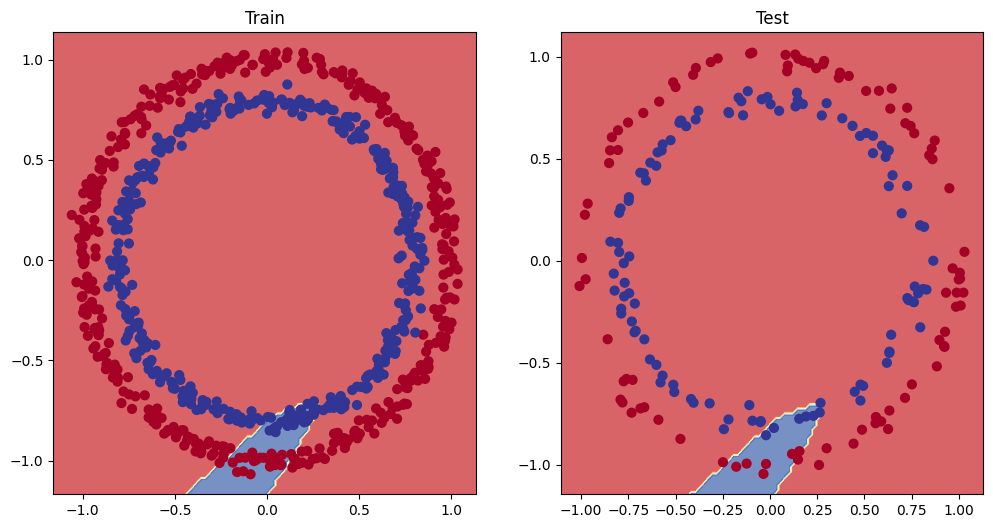

In [ ]:
#plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

##Replicating non linear activation function

In [ ]:
#create tensor
A = torch.arange(-10,10,1, dtype=torch.float32).unsqueeze(dim=1)
A

tensor([[-10.],
        [ -9.],
        [ -8.],
        [ -7.],
        [ -6.],
        [ -5.],
        [ -4.],
        [ -3.],
        [ -2.],
        [ -1.],
        [  0.],
        [  1.],
        [  2.],
        [  3.],
        [  4.],
        [  5.],
        [  6.],
        [  7.],
        [  8.],
        [  9.]])

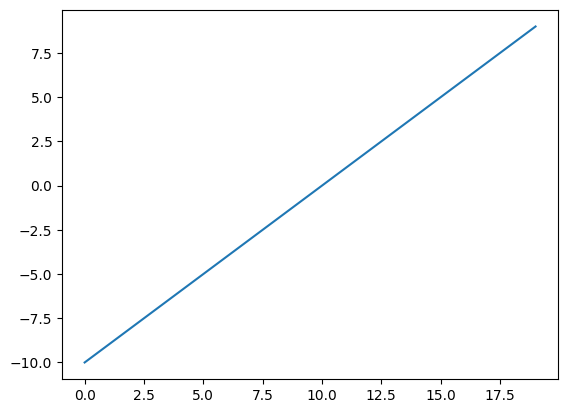

In [ ]:
plt.plot(A)

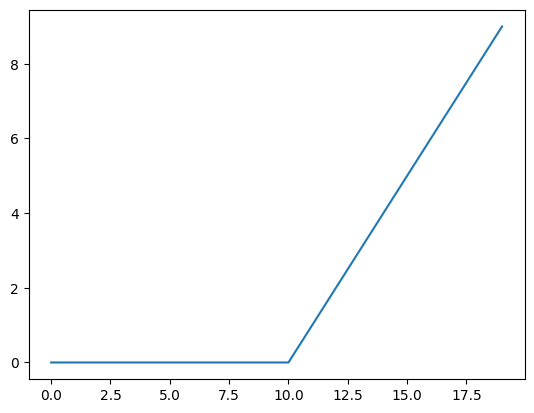

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x:torch.tensor)->torch.tensor:
  return torch.max(torch.tensor(0),x)
relu(A)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

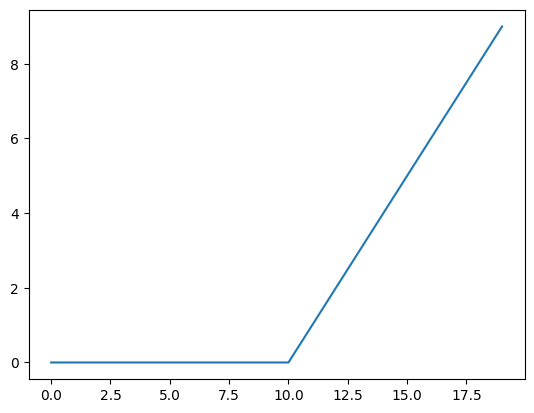

In [ ]:
plt.plot(relu(A))

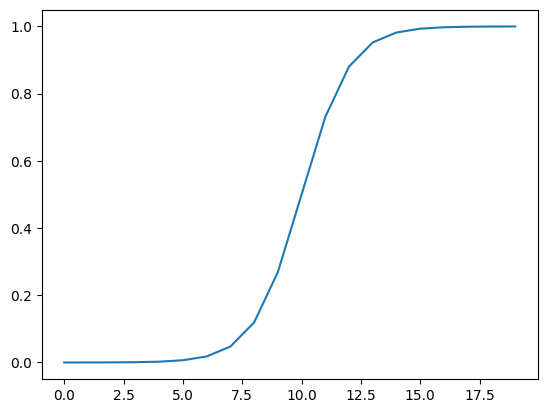

In [ ]:
#lets do for sigmoid
plt.plot(torch.sigmoid(A))

In [ ]:
def sigmoid(x):
  return 1/(1+torch.exp(-x))
sigmoid(A)

tensor([[4.5398e-05],
        [1.2339e-04],
        [3.3535e-04],
        [9.1105e-04],
        [2.4726e-03],
        [6.6929e-03],
        [1.7986e-02],
        [4.7426e-02],
        [1.1920e-01],
        [2.6894e-01],
        [5.0000e-01],
        [7.3106e-01],
        [8.8080e-01],
        [9.5257e-01],
        [9.8201e-01],
        [9.9331e-01],
        [9.9753e-01],
        [9.9909e-01],
        [9.9966e-01],
        [9.9988e-01]])

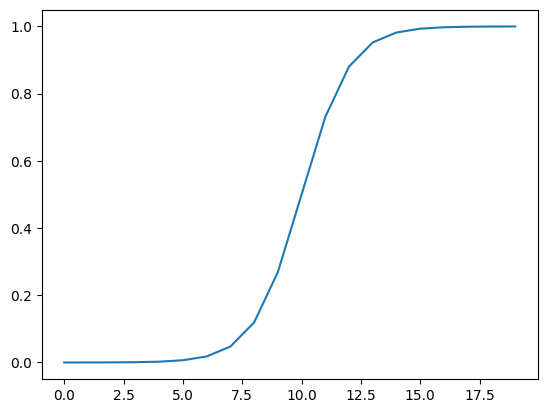

In [ ]:
plt.plot(sigmoid(A))

#8.Multiclass Classification

##8.1 Creating a toy multiclass classification dataset

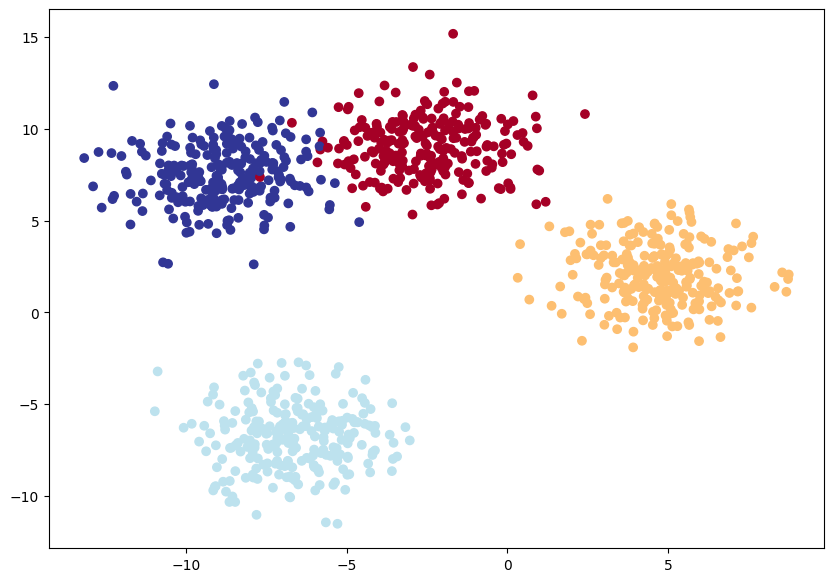

In [ ]:
#import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
#set hyperparams
Num_classes = 4
Num_features = 2
RANDOM_SEED = 42
#1. create multiclass data
X_blob , y_blob = make_blobs(n_samples=1000, n_features = Num_features, centers = Num_classes, cluster_std=1.6, random_state=RANDOM_SEED)
#2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
#3. split data into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)
#X_train[:5],y_train[:5]
#4. Visualize the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

##8.2 Building a multiclass classification data in pytorch


In [ ]:
#Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
#Build a multiclass classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        #nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)
#create an instance of BlobModel
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [ ]:
y_blob_train[:5]

tensor([1, 0, 2, 2, 0])

In [ ]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

##8.3 Create loss function and optimizer for multiclass classification

In [ ]:
#create a loss fun
loss_fn = nn.CrossEntropyLoss()
#set up optimizer
optimizer= torch.optim.SGD(params=model_4.parameters(), lr=0.1)

##8.4 Getting prediction probabilities for multiclass PyTorch model
in oreder to train and eval and test our model,we need to convert model's outputs(logits) to prediction probablities and then to prediction labels.

Logits->pred probs->pred labels

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:10]
#model_4(X_blob_test.to(device))

tensor([[-1.2661, -0.8338, -1.4951, -0.5615],
        [ 1.7048, -1.2227,  1.7242,  2.0882],
        [ 2.2343,  0.7805,  2.5970,  0.9994],
        [-0.7801, -0.3656, -0.8918, -0.5286],
        [-0.4771, -1.6209, -0.7388,  0.6573],
        [ 2.1006, -1.3781,  2.1381,  2.5193],
        [ 1.7981,  0.9018,  2.1335,  0.5619],
        [ 0.1356, -1.4742, -0.0422,  1.0328],
        [ 2.9838,  0.7093,  3.4130,  1.6476],
        [-0.0838, -1.5023, -0.2881,  0.8800]])

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [ ]:
#convert our models logits to prediction probablities
y_pred_probs= torch.softmax(y_logits,dim=1)
y_logits[:5],y_pred_probs[:5]

(tensor([[-1.2661, -0.8338, -1.4951, -0.5615],
         [ 1.7048, -1.2227,  1.7242,  2.0882],
         [ 2.2343,  0.7805,  2.5970,  0.9994],
         [-0.7801, -0.3656, -0.8918, -0.5286],
         [-0.4771, -1.6209, -0.7388,  0.6573]]),
 tensor([[0.1866, 0.2875, 0.1484, 0.3775],
         [0.2825, 0.0151, 0.2880, 0.4144],
         [0.3376, 0.0789, 0.4853, 0.0982],
         [0.2130, 0.3225, 0.1905, 0.2740],
         [0.1924, 0.0613, 0.1481, 0.5982]]))

In [ ]:
#convert models pred prob to pred labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2,
        2, 2, 3, 3, 3, 3, 3, 1, 1, 2, 1, 2, 1, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 1, 2, 2, 3, 1, 3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 3, 3, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 1, 1, 3, 2, 2, 3, 3, 3, 1, 2,
        2, 3, 3, 1, 2, 3, 3, 3, 2, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 1, 1, 3, 2, 2,
        2, 2, 3, 3, 3, 2, 2, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3,
        2, 2, 2, 3, 3, 1, 1, 1, 1, 1, 3, 1, 3, 2, 2, 3, 2, 2, 3, 3, 2, 2, 3, 3,
        1, 3, 2, 3, 3, 1, 2, 3])

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [ ]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

##8.5 Create a training and testing loop for multiclass model

In [ ]:
#fit the multiclass model to data
torch.manual_seed(42)
#set number of epochs
epochs = 1000
#put data to target device
X_blob_train, X_blob_test, y_blob_train, y_blob_test = X_blob_train.to(device), X_blob_test.to(device), y_blob_train.to(device), y_blob_test.to(device)
for epoch in range(epochs):
  #training
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  ##testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test).squeeze()
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)
    ##print whats happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04478 | Acc: 64.88% | Test Loss: 0.58207 | Test Acc: 94.50%
Epoch: 100 | Loss: 0.04123 | Acc: 98.75% | Test Loss: 0.03064 | Test Acc: 99.50%
Epoch: 200 | Loss: 0.03666 | Acc: 98.75% | Test Loss: 0.02485 | Test Acc: 99.50%
Epoch: 300 | Loss: 0.03525 | Acc: 98.75% | Test Loss: 0.02283 | Test Acc: 99.50%
Epoch: 400 | Loss: 0.03447 | Acc: 98.75% | Test Loss: 0.02169 | Test Acc: 99.50%
Epoch: 500 | Loss: 0.03390 | Acc: 98.75% | Test Loss: 0.02088 | Test Acc: 99.50%
Epoch: 600 | Loss: 0.03342 | Acc: 98.75% | Test Loss: 0.02024 | Test Acc: 99.50%
Epoch: 700 | Loss: 0.03300 | Acc: 98.88% | Test Loss: 0.01970 | Test Acc: 99.50%
Epoch: 800 | Loss: 0.03261 | Acc: 98.88% | Test Loss: 0.01922 | Test Acc: 99.50%
Epoch: 900 | Loss: 0.03224 | Acc: 98.88% | Test Loss: 0.01878 | Test Acc: 99.50%


##8.6 making predictions and evaluating with multiclass pytorch model

In [ ]:
#make predictios
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_logits[:10],y_pred[:10]

(tensor([[  5.8756,  17.3480, -21.9648, -13.2635],
         [  9.3105, -21.5152,   4.2438,  16.4482],
         [ -7.9005, -18.6633,  28.2298,  14.2569],
         [  1.8643,  13.4993, -12.7212, -10.3240],
         [ 12.6689,   3.8001, -21.3776,  -2.9023],
         [ 10.6599, -27.1815,   6.7686,  20.7808],
         [ -8.9568, -12.6537,  24.9795,   9.6621],
         [ 11.4256,  -3.1436, -13.8578,   2.4052],
         [ -7.2650, -28.3407,  35.0920,  21.6553],
         [ 11.6611,  -0.5417, -16.3236,   0.4162]]),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

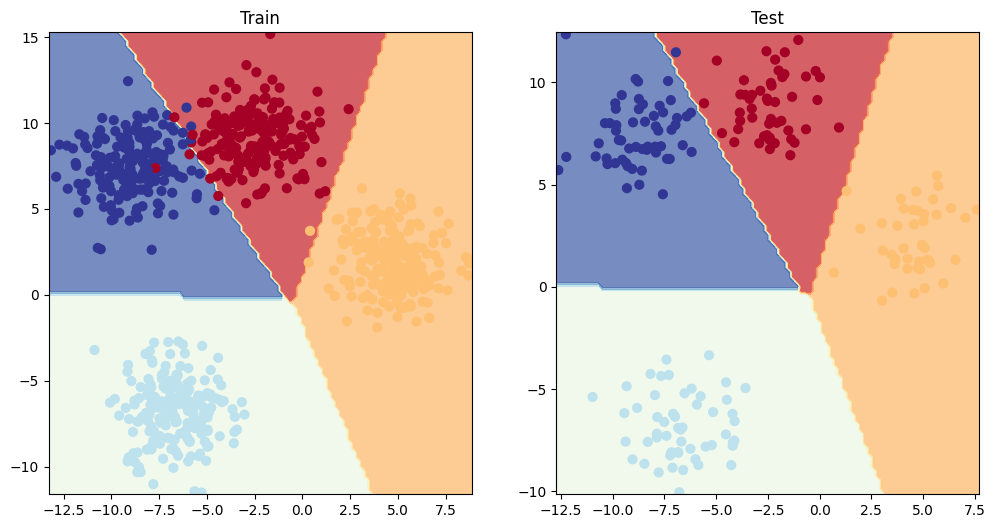

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

#9 A few more classification metrics
  ->Accuracy- out of 100 samples how many does model get right#not best for imbalanced classes.
  
  ->Precision- higher precision leads to less false positive

  ->Recall-> higher recall leads to lesser false negatives

  ->F1 score-> combination of precision and recall

  ->confusion matrix

  ->classification report


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
from torchmetrics import Accuracy
#setup metric
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
#calculate accuracy
#accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
torchmetrics_accuracy(y_pred, y_blob_test)

tensor(0.9950)